In [71]:
import pandas as pd
import numpy as np
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Conv1D, Dense, MaxPooling1D, GlobalMaxPooling1D, Embedding, Dropout
from keras.models import Model

In [7]:
df = pd.read_csv('hewlett-essay-train.tsv', sep='\t', encoding='latin-1', index_col=0)

In [15]:
X = df[df['essay_set'] == 1]['essay']

y = df[df['essay_set'] == 1]['domain1_score']

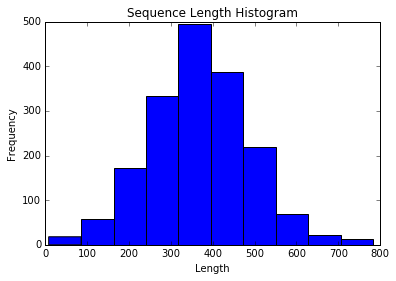

In [60]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X.values)
sequences = tokenizer.texts_to_sequences(X.values)
word_index = tokenizer.word_index

%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(list(map(lambda seq: len(seq), sequences)))
plt.title("Sequence Length Histogram")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()


In [30]:
print ('Set contains {} unique words'.format(len(tokenizer.word_index)))

Set contains 16257 unique words


In [ ]:
data = pad_sequences(sequences)

labels = np_utils.to_categorical(np.asarray(y.values))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

In [65]:
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH = 783
LABELS_COUNT = 13

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

Train on 1426 samples, validate on 357 samples
Epoch 1/100
1426/1426 [==============================] - 2s - loss: 2.5649 - acc: 0.3520 - val_loss: 2.5649 - val_acc: 0.3838
Epoch 2/100
1426/1426 [==============================] - 1s - loss: 2.5649 - acc: 0.3857 - val_loss: 2.5649 - val_acc: 0.3838
Epoch 3/100
1426/1426 [==============================] - 1s - loss: 2.5649 - acc: 0.3857 - val_loss: 2.5649 - val_acc: 0.3838
Epoch 4/100
1426/1426 [==============================] - 1s - loss: 2.5649 - acc: 0.3857 - val_loss: 2.5649 - val_acc: 0.3838
Epoch 5/100
1426/1426 [==============================] - 1s - loss: 2.5649 - acc: 0.3857 - val_loss: 2.5649 - val_acc: 0.3838
Epoch 6/100
1426/1426 [==============================] - 1s - loss: 2.5649 - acc: 0.3857 - val_loss: 2.5649 - val_acc: 0.3838
Epoch 7/100
1426/1426 [==============================] - 1s - loss: 2.5649 - acc: 0.3857 - val_loss: 2.5649 - val_acc: 0.3838
Epoch 8/100
1426/1426 [==============================] - 1s - loss: 2.5

1426/1426 [==============================] - 1s - loss: 2.5648 - acc: 0.3857 - val_loss: 2.5648 - val_acc: 0.3838
Epoch 66/100
1426/1426 [==============================] - 1s - loss: 2.5648 - acc: 0.3857 - val_loss: 2.5648 - val_acc: 0.3838
Epoch 67/100
1426/1426 [==============================] - 1s - loss: 2.5648 - acc: 0.3857 - val_loss: 2.5648 - val_acc: 0.3838
Epoch 68/100
1426/1426 [==============================] - 1s - loss: 2.5648 - acc: 0.3857 - val_loss: 2.5648 - val_acc: 0.3838
Epoch 69/100
1426/1426 [==============================] - 1s - loss: 2.5648 - acc: 0.3857 - val_loss: 2.5648 - val_acc: 0.3838
Epoch 70/100
1426/1426 [==============================] - 1s - loss: 2.5648 - acc: 0.3857 - val_loss: 2.5648 - val_acc: 0.3838
Epoch 71/100
1426/1426 [==============================] - 1s - loss: 2.5648 - acc: 0.3857 - val_loss: 2.5648 - val_acc: 0.3838
Epoch 72/100
1426/1426 [==============================] - 1s - loss: 2.5648 - acc: 0.3857 - val_loss: 2.5648 - val_acc: 0.38

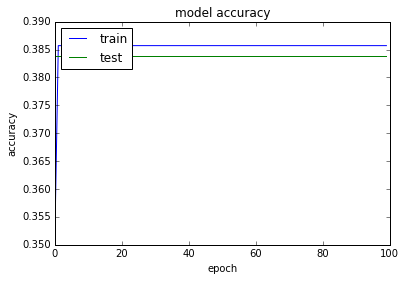

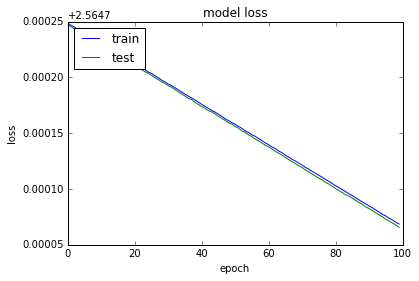

In [90]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            embeddings_initializer = 'glorot_uniform', # not using pre-trained embeddings
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(32, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(.5)(x)
x = Conv1D(32, 5, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(.5)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)  # global max pooling
x = Dropout(.5)(x)
#x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(LABELS_COUNT, activation='softmax')(x)


model = Model(sequence_input, preds)

from keras import optimizers

opt = optimizers.SGD(lr = .000001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

# happy learning!
history = model.fit(data, labels, validation_split = .2, epochs=100, batch_size=128)

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()